# Diagnosing and mitigating bias in word embeddings

Based on the tutorial https://learn.responsibly.ai/word-embedding
and its [notebook](https://colab.research.google.com/github/ResponsiblyAI/word-embedding/blob/main/tutorial-bias-word-embedding.ipynb).

Powered by [`responsibly`](https://docs.responsibly.ai/) - Toolkit for auditing and mitigating bias of machine learning systems.

This is a shortened version of the original tutorial. For more extensive context, references and explanations, refer to https://learn.responsibly.ai/.


## Disclaimer

Aiming for simplicity in the explanation, the concept of gender is oversimplified, treated as binary. Nevertheless, gender is a complex social construct. This should kept in mind when we go back from a learning context to the real-world.


## Overview

In this 45 minute tutorial, we will explore bias in **word embeddings** - a widespread building block of many machine learning models that work with human languages. 

A word embedding is an n-dimensional space where words are represented as vectors. In such space, words with similar behavior in text are close to each other. Following the **distributional hypothesis** (Harris 1954), behavior in text is often used as a proxy for the meaning of words. 

The dimensions in this particular space have been found  by a neural network, processing huge amounts of raw text data, such as news, wikipedia articles, reddit posts, tweets, etc. However, the resulting space is not intepretable at human level, since the resulting dimensions display no meaning that can be understood using common knowledge or common sense.

Nevertheles, word embeddings have an easy-to-explain geometrical representation that allows an intuitive understanding of this building block and its potential biases. 

Bias can affect any aspect of human judgement. To illustrate the phenomenon and how to address it in word embeddings, we focus on **gender** bias. We use an oversimplified representation of gender, considering only binary gender. This simplification is aimed to improve understanding of the techniques, and needs to be specifically worked out for actual deployment in applications. 

## What we will be doing in this tutorial: 

1. **Define:** We have decided that we wish to work on gender bias, but gender bias is a very complex phenomena. First of all, we will **narrow down** our definition to be able to apply the available techniques. 
We will be working specifically on gender bias with respect to *occupations*.  

2. **Diagnose:** Determine whether our embedding model has observable bias according to our definition based on occupations.

3. **Mitigate:** Once we've observed some bias in our embedding, we will apply some techniques to reduce the effect of bias in the embedding.

In order to do that, we use the techniques developed by [Bolukbasi et all](https://arxiv.org/pdf/1607.06520.pdf) (2016). They consist in: 

1. **Identifying the gender sub-space within the embedding space**: we will be characterizing a direction, or in a more general sense a sub-space, in which we can distinguish the components of the gender bias. 

2. In order to mitigate the bias but also be able to mantain the desirable and useful characteristics of the embedding, there are 2 techniques that the authors presents and are available in ```responsibly```:

  2.1. **Neutralize**: given a *set of words that should be unbiased*, in our case professions that should be gender neutral, this technique ensures that these words are in the middle of the previously identified subspace.

  2.2 **Equalize**: this technique works on *words* that should be neutral regarding to sets of words that represent a concept in different gender directions, for example {grandmother, grandfather}. After the equalization, the words that we consider should be neutral regarding gender (or the particular bias) will be equidistant to all the words of the set.

In this short version we will only be working on neutralization.

In all these techniques we refer to *sets of words* that are relevant to our bias analysis. These sets of words are a **key component** in all of the techniques we will be working on this workshop, and should be carefully elaborated for each particular use case.

We encourage you to work beyond the gender example and try to model forms of bias that are relevant for your community. Try to formalize them as binary concepts and find words that should be gender neutral!

There are many examples of the impact of bias
in language technology.
In [`this notebook`](https://colab.research.google.com/drive/1leU5YU_XYzq8Mcn5xqLivkRycorncxnW) we've collected a few.

 # Part 0: Setup

## 🛠️ Install `responsibly`

In [ ]:
%pip install --user responsibly

     |████████████████████████████████| 28.2MB 139kB/s 
     |████████████████████████████████| 24.2MB 2.5MB/s 
     |████████████████████████████████| 12.8MB 18.5MB/s 
ERROR: plotnine 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: mizani 0.6.0 has requirement matplotlib>=3.1.1, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: arviz 0.11.2 has requirement matplotlib>=3.0, but you'll have matplotlib 2.2.5 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.



**Restart** the Kernel/Runtime (use the menu on top or the botton in the notebook), **skip** the installation cell (`!pip install --user responsibly`) and **run** the cell below (`import responsibly`)

## 🛠️Validate the installation

In [ ]:
import responsibly

# You should get '0.1.3'
responsibly.__version__


'0.1.3'

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Part 1: Playing with Word Embeddings

## 1.1 Introduction and references

When it comes to language modeling, it is clear that words are not that easy to represent in a way that captures the complexity of human language. In the case of images, for example, we translate a picture into vectors which represents pixels and their intensity, color, brightness, etc. We transform an image into a mathematical object that computers can manipulate. So, how can we represent words in a machine-usable way?

There are many ways to do so, but in this tutorial we will be focusing on word embeddings. A word embedding is a learned representation for text where words that have similar meanings tend to have similar representations. But what does it mean that words have similar meanings? How can we "teach" that to a computer?


**Distributional Hypothesis**

> "a word is characterized by the company it keeps" - [John Rupert Firth](https://en.wikipedia.org/wiki/John_Rupert_Firth)

Based on this hypothesis, word embeddings aim to represent words characterizing them by their contexts of occurrence, roughly following these steps:

1. Gather huge amounts of text, say, all Wikipedia articles; then
2. break text down into all possible substrings, using a sliding window along text;
3. consider each substring as a training example for a neural network. This network tries to learn how to predict the context given one of the words in the substring, or it tries to predict one of the words given the context, that is, the rest of the words in the substring;
4. once a neural network is trained with such examples, take the last-but-one layer as the space where words will be now represented, so that each neuron in that layer is a dimension of the embedding space.

If you are curious about the details, [this post gives a very understandable visual introduction and pointers to reference work](http://jalammar.github.io/illustrated-word2vec/). 

It is important to note that, since embeddings are obtained from text created by people, they will naturally reflect their biases and prejudices. They should not be viewed as objective or neutral, but rather as a social construct, with the complexities of our societies.

## 1.2 Dataset and basic properties

The library [`responsibly`](http://docs.responsibly.ai) has the function [`responsibly.we.load_w2v_small`]() which returns  [`KeyedVectors`](https://radimrehurek.com/gensim/models/keyedvectors.html#gensim.models.keyedvectors.KeyedVectors) de [`gensim`](https://radimrehurek.com/gensim/). These word embeddings were trained using Google News: 100B tokens, 3 millon vocabulary, 300 dimensions vectors.

For more information: [Word2Vec](https://code.google.com/archive/p/word2vec/) - 

In [ ]:
from responsibly.we import load_w2v_small

w2v_small = load_w2v_small()

In [ ]:
# dataset vocabulary size

len(w2v_small.vocab)

26423

In [ ]:
# get the vector of the word "love"

print('love =', w2v_small['love'])

love = [ 0.0386357  -0.0571296   0.00970471  0.0618904  -0.0618904   0.0250858
  0.109865   -0.0988782  -0.0527351   0.0754404  -0.00984205 -0.0307621
 -0.0103914  -0.0164797  -0.088258    0.0637215   0.0483405   0.0589607
  0.00283817 -0.0261844  -0.0144655   0.0298466   0.0860607  -0.0538337
  0.0629891  -0.0131838   0.0206912   0.0401006   0.0419317  -0.061158
 -0.0419317   0.0523688   0.00583656  0.0479742   0.0578621   0.028931
  0.0981458   0.0324101  -0.00943005  0.125246    0.0699472  -0.0787364
  0.0265506   0.00975049 -0.0399175  -0.0384526   0.0461432   0.0176699
  0.00828563  0.0218814  -0.0411993   0.056031   -0.0401006   0.00583656
  0.0336918   0.0421148  -0.0163881  -0.0426641  -0.00140192 -0.00682077
  0.0911877   0.0316777  -0.0265506   0.0677499   0.0131838  -0.0362553
 -0.0823985  -0.00123026 -0.0119936   0.0692148   0.106935   -0.032227
 -0.0419317   0.00801097 -0.114992   -0.0346074  -0.0710458   0.00567634
  0.069581    0.128908   -0.116457    0.0845958   0.03277

There is not much to see for us humans. While really useful, are not easily interpretable. The encoding of the semantics of the word is not transparent to us users, there is not a direct relationship between the value of the vector coordinate and a particular word meaning. They encode lots of information in a sort of criptic way. So, is there a way to detect/diagnose/observe bias in word embeddings?

## 1.3 Measuring distance between words

### Measure of Similiarty: [Cosine Similariy](https://en.wikipedia.org/wiki/Cosine_similarity)
- Measures the cosine of the angle between two vectors.
- Ranges between 1 (same vector) to -1 (opposite vector)

In [ ]:
w2v_small['cat'] @ w2v_small['cat']

1.0000006

In [ ]:
w2v_small['cat'] @ w2v_small['cats']

0.8099383

In [ ]:
w2v_small['cat'] @ w2v_small['dog']

0.7609462

In [ ]:
w2v_small['cat'] @ w2v_small['horse']

0.38147917

In [ ]:
w2v_small['cat'] @ w2v_small['finance']

-0.037760373

In [ ]:
w2v_small.most_similar('cat', topn=5)

[('cats', 0.8099379539489746),
 ('dog', 0.7609457969665527),
 ('kitten', 0.7464984655380249),
 ('feline', 0.7326232194900513),
 ('puppy', 0.707545280456543)]

###Let's find "the odd one out"

In [ ]:
w2v_small.doesnt_match('hairdresser nurse man woman housekeeper personal_trainer'.split())

'nurse'

In [ ]:
w2v_small.doesnt_match('hairdresser nurse man woman housekeeper manager'.split())

'manager'

In [ ]:
w2v_small.doesnt_match('hairdresser nurse man men housekeeper manager'.split())

'manager'

In [ ]:
w2v_small.doesnt_match('hairdresser nurse woman women housekeeper manager'.split())

'manager'

## 1.4 Visualization of Word Embedding using T-SNE

Below you can find a visualization of word embeddings, a projection of a 300-dimensional embedding to a two-dimensional space. We can see that words with similar meanings tend to be close, like "*yesterday*", "*summer*" or "*morning*", "*ever*" and "*never*", "*started*" and "*began*"...

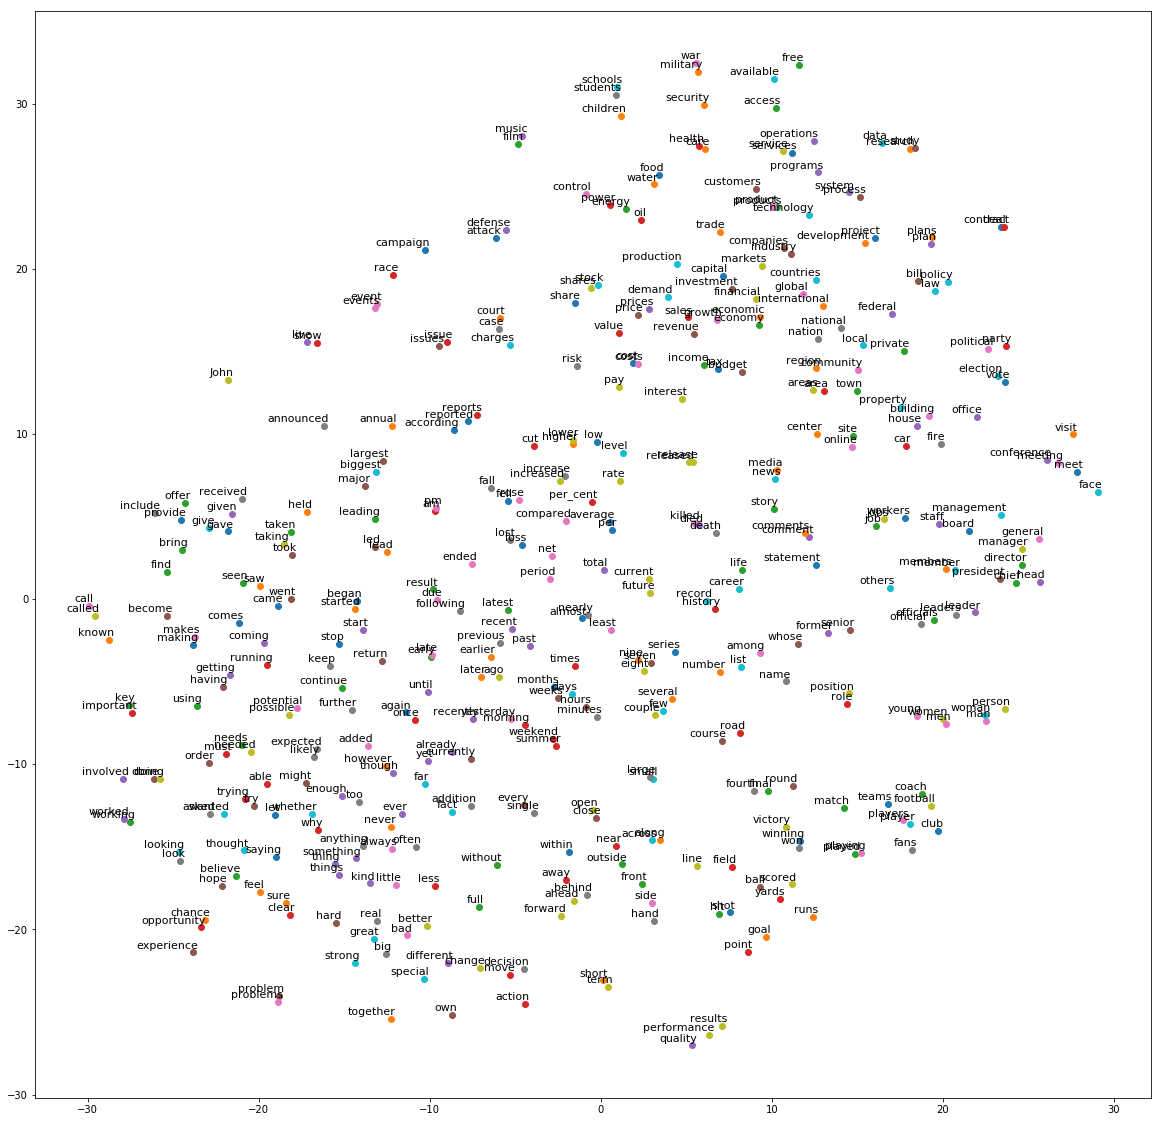

In [ ]:
from sklearn.manifold import TSNE
from matplotlib import pylab as plt

# take the most common words in the corpus between 200 and 600
words = [word for word in w2v_small.index2word[200:600]]

# convert the words to vectors
embeddings = [w2v_small[word] for word in words]

# perform T-SNE
words_embedded = TSNE(n_components=2).fit_transform(embeddings)

# ... and visualize!
plt.figure(figsize=(20, 20))
for i, label in enumerate(words):
    x, y = words_embedded[i, :]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                 ha='right', va='bottom', size=11)
plt.show()

To get a grasp on some basic embeddings properties, check [this notebook](https://colab.research.google.com/drive/1oCTFCSSkB08_ASWDkpsFYzjW3PvbI60b?usp=sharing)

## 1.5 Vector analogies

One interesting property about word embeddings is that we can easily generate analogies. How do we do that? For example, if we want to obtain an analogy of the form "*man is to king as woman is to ?*", we substract "*man*" from "*king + woman*". 
Intuitively, we are factoring out the "*man*" part of the combination between a king and a woman.

<img src="https://github.com/ResponsiblyAI/word-embedding/blob/main/images/linear-relationships.png?raw=1" />

<small>Source: [Tensorflow Documentation](https://www.tensorflow.org/tutorials/representation/word2vec)</small>


Keep in mind the word embedding was generated by learning the co-occurrence of words, so the fact that it *empirically* exhibit "concept arithmetic", it doesn't necessarily mean it learned meaning! In fact, it seems it didn't, but rather, it seems it learns how words behave but not the meaning they convey.
See: [king - man + woman is queen; but why? by Piotr Migdał](https://p.migdal.pl/2017/01/06/king-man-woman-queen-why.html)

With these vectors, we can perform the kind of arithmetic operations described above:

In [ ]:
# small is to smaller as good is to what?
w2v_small.most_similar(positive=['good', 'smaller'], negative=['small'], topn=2)

[('better', 0.7270160913467407), ('stronger', 0.5597214102745056)]

In [ ]:
# man is to carpenter as woman is to what?

w2v_small.most_similar(positive=['carpenter', 'woman'], negative=['men'], topn=2)

[('schoolteacher', 0.590914785861969), ('homemaker', 0.5572819709777832)]

With these analogies we can start **exploring** our embedding to detect possible harmful bias.

# Part 2: Diagnosing Gender Bias

Given that the representation of a word in an embedding space is a vector, how can we **observe** bias? Can vectors be biased? What does that even mean?

## 2.1 Words with mophological gender

There are many words that are gender marked in their form, for example, "*brother-sister*". These words convey gender through their morphology. They do not necessarily reflect a stereotype, but a morphological characteristic of the words. Other words that convey gender are queen-king, mother-father, waiter-waitress.

In [ ]:
# She is to sister as he is to what?
# sister - she + he = ?

w2v_small.most_similar(positive=['sister', 'he'], negative=['she'], topn=5)

[('brother', 0.7627110481262207),
 ('younger_brother', 0.6856132745742798),
 ('cousin', 0.6685015559196472),
 ('uncle', 0.6580697894096375),
 ('nephew', 0.65260249376297)]

## 2.2 Words with gender stereotypes 

In contrast, some words do not have a gender meaning morphologically, but are associated gender meanings by sterotyped usage. This happens because the contexts of occurrence of such words are biased toward some specific gender, reflecting how people actually use those words. Some words representing professions are markedly biased with respect to gender, because they tend to be associated to male or female roles. Here we here we explore such words the analogy mechanism.

In [ ]:
#She is to interior designer as he is to what?
w2v_small.most_similar(positive=['interior_designer', 'he'], negative=['she'], topn=4)

[('architect', 0.623257040977478),
 ('carpenter', 0.46738606691360474),
 ('painter', 0.4598923623561859),
 ('restaurateur', 0.4586508572101593)]

Here other female-male stereotypes that you can explore. 

```
nurse-doctor
sewing-carpentry
volleyball-football
interior_designer-architect
feminism-conservatism
vocalist-guitarist
diva-superstar
cupcakes-pizzas
hairdresser-barber
```

## 2.3 Gender direction

Now, let's see an example of how binary meaning can be represented. Let's take our binary representation of the "*gender*" meaning.

### $\overrightarrow{she} - \overrightarrow{he}$
 

In [ ]:
from numpy.linalg import norm

gender_direction = w2v_small['she'] - w2v_small['he']

gender_direction /= norm(gender_direction)

In [ ]:
# the @ operator returns the cosine similarity of 2 normalized vectors
gender_direction @ w2v_small['architect']

-0.16785555

In [ ]:
gender_direction @ w2v_small['interior_designer']

0.19714224

**⚡Interpret carefully: The word *architect* appears in more contexts with *he* than with *she*, and vice versa for *interior designer*.**

In practice, we calculate the direction of the gender meaning subspace not only using "he" and "she", but using multiple pairs of words that represent each end of the meaning direction. This allows for better estimation, counterweighting the fact that words may have more than one meaning.

- woman - man
- girl - boy
- she - he
- mother - father
- daughter - son
- gal - guy
- female - male
- her - his
- herself - himself
- Mary - John

Note that **this list of words is a very important input** of the analysis, as it defines the meaning that we are trying to explore!

## 2.4 Try some words by yourself
Now think about some word: where in the gender direction is it located? nearing which end, and how near?


⚡ Keep in mind: You are performing exploratory data analysis, and not a systemic evaluation!

In [ ]:
gender_direction @ w2v_small['house']

0.07210897

In [ ]:
gender_direction @ w2v_small['home']

-0.016742865

## 2.5 Projections in the gender direction

Now we want to be more systematic in this exploration. 

We will be using a list of morphologically gender-neutral professions to do that. Gender-neutral words should be equally distant from both ends in the gender direction. We say that their bias should be around 0, and again we have a high-level construct to model that:

In [ ]:
from responsibly.we import GenderBiasWE

w2v_small_gender_bias = GenderBiasWE(w2v_small, only_lower=True)

In [ ]:
w2v_small_gender_bias.positive_end, w2v_small_gender_bias.negative_end

('she', 'he')

In [ ]:
# gender direction
w2v_small_gender_bias.direction[:10]

array([-0.10056252, -0.09987912, -0.05384335,  0.00480521,  0.01521063,
       -0.01666582,  0.00932552, -0.00625998, -0.11320096,  0.03992424])

In [ ]:
# list of gender neutral professions
from responsibly.we.data import BOLUKBASI_DATA

neutral_profession_names = BOLUKBASI_DATA['gender']['neutral_profession_names']

In [ ]:
neutral_profession_names[:8]

['accountant',
 'acquaintance',
 'actor',
 'adjunct_professor',
 'administrator',
 'adventurer',
 'advocate',
 'aide']

Note: Why `actor` is in the neutral profession names list while `actress` is not there?
1. Due to the statistical nature of the method that is used to find the gender- specific and natural words
2. That might be because `actor` nowadays is much more gender-neutral, compared to waiter-waitress (see [Wikipedia - The term Actress](https://en.wikipedia.org/wiki/Actor#The_term_actress))

In [ ]:
len(neutral_profession_names)

303

In [ ]:
# the same of using the @ operator on the bias direction

w2v_small_gender_bias.project_on_direction(neutral_profession_names[0])

0.008421647916552755

Let's visualize the projections of professions (neutral and specific by the orthography) on the gender direction:

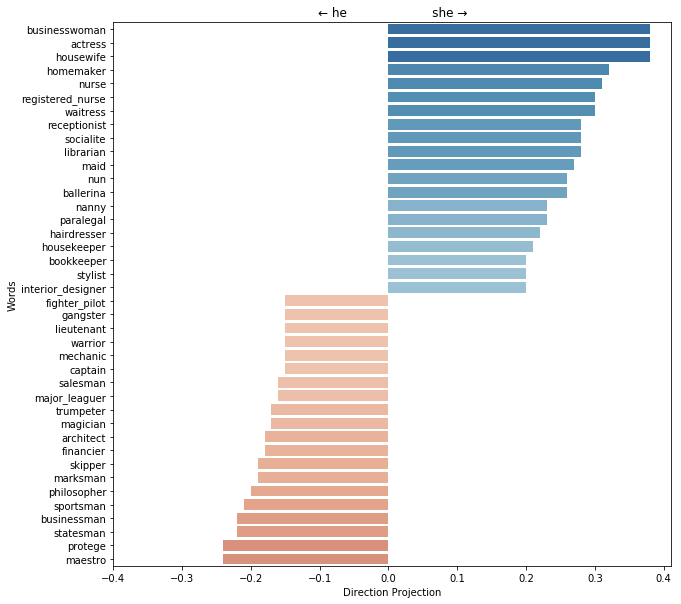

In [ ]:
import matplotlib.pylab as plt

f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_bias.plot_projection_scores(n_extreme=20, ax=ax);

They do not look very neutral, they edge towards one or the other end of the continuum.

EXTRA: Demo - Visualizing gender bias with [Word Clouds](http://wordbias.umiacs.umd.edu/)

The projections of occupation words on the gender direction are related to the real world!

Garg, N., Schiebinger, L., Jurafsky, D., & Zou, J. (2018). Word embeddings quantify 100 years of gender and ethnic stereotypes. Proceedings of the National Academy of Sciences, 115(16), E3635-E3644.

# Part 3: Hands on Mitigating Bias!

## 3.1 Direct Bias Measure

Now that we have modelled the gender direction (with words representing each end) and we have a representation of how an unbiased word embedding would be (via gender-neutral words), we can diagnose bias, in a very simple, systematic way:

1. Project each **neutral profession name** on the gender direction
2. Calculate the absolute value of each projection
3. Average it all

In [ ]:
# high-level function to calculate gender bias built into responsibly

w2v_small_gender_bias.calc_direct_bias()

0.07307905466893873

In [ ]:
# what responsibly does within the calc_direct_bias function:

neutral_profession_projections = [w2v_small[word] @ w2v_small_gender_bias.direction
                                  for word in neutral_profession_names]

abs_neutral_profession_projections = [abs(proj) for proj in neutral_profession_projections]

sum(abs_neutral_profession_projections) / len(abs_neutral_profession_projections)

0.0730790545759565

What are the assumptions of the direct bias measure? How does the choice of neutral words affect the definition of the bias? Can we measure **all** of the gender bias with this technique? 

An interesing property of this method is that it gives us a quantitative measure of the bias in the embedding, but keep in mind that this number only takes into consideration the bias present in the *assumed neutral* words with respect to the *defined gender direction*, which we agreed was a simplification of the actual phenomenon.

What about words that are not in the list? Is this list comprehensive enough?

## 3.2 Mitigating gender bias

> We intentionally do not reference the resulting embeddings as "debiased" or free from all gender bias, and
prefer the term "mitigating bias" rather that "debiasing," to guard against the misconception that the resulting
embeddings are entirely "safe" and need not be critically evaluated for bias in downstream tasks. 

<small>James-Sorenson, H., & Alvarez-Melis, D. (2019). [Probabilistic Bias Mitigation in Word Embeddings](https://arxiv.org/pdf/1910.14497.pdf). arXiv preprint arXiv:1910.14497.</small>

As an approach to mitigating bias, we will remove the gender projection from the words in the gender-neutral word list and then normalize.

This method *needs* a list of gender neutral words to neutralize, or a list of words that are inherently gendered to not neutralize. 

For this particular example on gender bias, responsibly defines a list of neutral words and neutralizes those words. These words are defined as the complement of the morphologically gendered words, and they are quite a few in English, because English is an [analytic language](https://en.wikipedia.org/wiki/Analytic_language).

In [201]:
len(w2v_small_gender_bias._data['neutral_words'])

26189

In [200]:
import random
print(random.sample(w2v_small_gender_bias._data['neutral_words'],10))

['sneaked', 'pipeline', 'involving', 'rodent', 'survived', 'affirmative_action', 'baptism', 'cushions', 'vibrancy', 'theoretical']


In [ ]:
# we obtain a version of the embeddings that is mitigated wrt the gender direction
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [ ]:
# measure of bias in the original embeddings
w2v_small_gender_bias.calc_direct_bias()

0.07307905479130264

In [ ]:
# measure of bias in the mitigated embeddings
w2v_small_gender_debias.calc_direct_bias()

1.1615064677713404e-09

In [ ]:
'home' in (w2v_small_gender_bias._data['neutral_words'])

True

In [ ]:
print('home:',
      'before =', w2v_small_gender_bias.model['home'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['home'] @ w2v_small_gender_debias.direction)

home: before = 0.011340496779172263 after =  -1.176245451061858e-09


In [ ]:
print('architect:',
      'before =', w2v_small_gender_bias.model['architect'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['architect'] @ w2v_small_gender_debias.direction)

architect: before = -0.17738309189742663 after =  -4.154597475580876e-10


In [ ]:
print('interior_designer:',
      'before =', w2v_small_gender_bias.model['interior_designer'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['interior_designer'] @ w2v_small_gender_debias.direction)

interior_designer: before = 0.19845774284382506 after =  2.8877261946752195e-09


In [182]:
'man' in (w2v_small_gender_bias._data['neutral_words'])

False

In [ ]:
print('man:',
      'before =', w2v_small_gender_bias.model['man'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['man'] @ w2v_small_gender_debias.direction)

man: before = -0.22095192936041713 after =  -0.2209519293604172


In [ ]:
print('woman:',
      'before =', w2v_small_gender_bias.model['woman'] @ w2v_small_gender_bias.direction,
      'after = ', w2v_small_gender_debias.model['woman'] @ w2v_small_gender_debias.direction)

woman: before = 0.3403474745246814 after =  0.3403474745246813


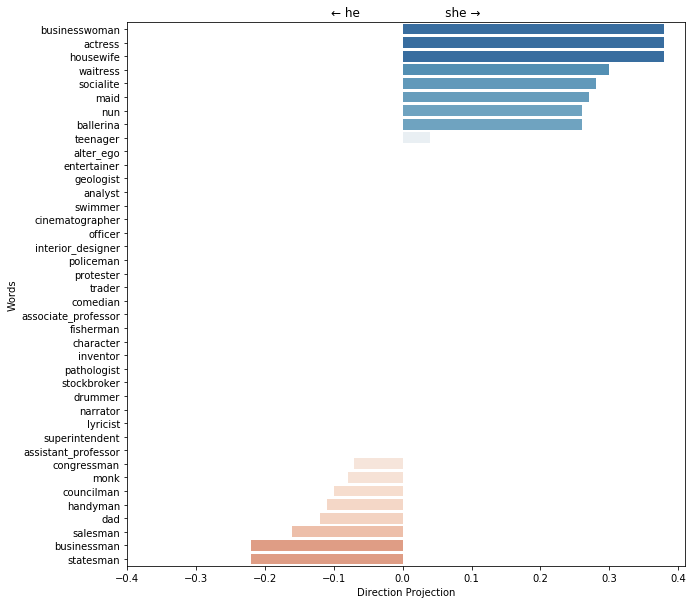

In [ ]:
f, ax = plt.subplots(1, figsize=(10, 10))

w2v_small_gender_debias.plot_projection_scores(n_extreme=20, ax=ax);

If you liked this exploration on gender bias, maybe you will want to take a look at an exploration on racial bias in the [original notebook](https://colab.research.google.com/github/ResponsiblyAI/word-embedding/blob/main/tutorial-bias-word-embedding.ipynb).

# Parte 4: Ahora en castellano!

Vamos a ver ahora cómo se trasladan estas técnicas a otro idioma.

El castellano es una lengua con varias diferencias con respecto al inglés:
- la mayoría de las palabras tienen **género marcado explícitamente en su forma**. Por lo tanto, será difícil obtener una lista de palabras neutras con respecto al género, que responsibly define muy fácilmente para el inglés.
- se pueden **omitir los sujetos** de las oraciones, por lo tanto, las ocurrencias de "*él*" y "*ella*" tendrán una distribución muy diferente que las de "*he*" y "*she*".

Con estas diferencias ¿resultarán efectivas las estrategias desarrolladas para el inglés?

Vamos a analizar los [word embeddings para el castellano](http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.vec.gz) obtenidos mediante [fastText](https://fasttext.cc/) a partir del [Spanish Billion Words Corpus](https://github.com/crscardellino/sbwce). Este embedding representa 855.380 palabras en 300 dimensiones, obteniendo sus contextos de ocurrencia a partir de 1'4 billones de palabras. Para este ejemplo usaremos solamente las 100000 palabras más frecuentes, así se ejecutará todo más rápido.

A diferencia de los embeddings obtenidos con word2vec, los embeddings obtenidos con fastText procesan también cadenas de caracteres dentro de las palabras, lo cual es muy adecuado para modelar lenguas donde las palabras tienen muchas variaciones en la forma, como el castellano, que es una [lengua de tipología fusionante](https://es.wikipedia.org/wiki/Lengua_fusionante). Efectivamente, mientras que en inglés (una [lengua aislante](https://es.wikipedia.org/wiki/Lengua_aislante)) las palabras tienen pocas formas diferentes, en castellano las palabras tienen muchas, porque significados como género, número, o tiempo verbal se expresan como variaciones en la forma de la palabra: "*escribirá, escribiremos, escribirían*".

Empecemos por obtener datos y librerías.

In [71]:
*# Descargar el modelo e importar librerías necesarias
import numpy as np
import logging

from numpy.linalg import norm
from gensim.models import KeyedVectors
from sklearn.metrics import classification_report, accuracy_score

logging.basicConfig(format='%(asctime)s : %(message)s', level=logging.INFO)

!wget -q http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.100k.vec.gz

!gzip -d -q fasttext-sbwc.100k.vec.gz
!ls

fasttext-sbwc.100k.vec	sample_data


In [72]:
we = KeyedVectors.load_word2vec_format('fasttext-sbwc.100k.vec')
# Esto normaliza los vectores
we.init_sims(replace=True)

2021-06-15 22:24:13,448 : loading projection weights from fasttext-sbwc.100k.vec
2021-06-15 22:24:45,186 : loaded (100000, 300) matrix from fasttext-sbwc.100k.vec
2021-06-15 22:24:45,190 : precomputing L2-norms of word weight vectors


In [73]:
# definimos cuándo dos vectores son "casi iguales" en este embedding

from numpy.testing import assert_almost_equal

length_vectors = norm(we.vectors_norm, axis=1)

assert_almost_equal(actual=length_vectors,
                    desired=1,
                    decimal=5)

## 4.1 Palabras con estereotipo de género

En castellano casi todas las palabras tienen género morfológico explícito, así que vamos a centrarnos directamente en las que reflejan estereotipos de género.

Vemos que la aritmética de vectores produce unos resultados bastante comparables a los del inglés.

In [ ]:
we.most_similar(positive=['doctor'],negative=['mujer'])

[('dr', 0.4176639914512634),
 ('licenciado', 0.3791270852088928),
 ('doctores', 0.3671714663505554),
 ('honoris', 0.3577732443809509),
 ('professor', 0.34742414951324463),
 ('neurólogo', 0.3422521650791168),
 ('cirujano', 0.33602601289749146),
 ('traumatólogo', 0.3323988914489746),
 ('profesor', 0.33126506209373474),
 ('cardiólogo', 0.3256565034389496)]

In [ ]:
we.most_similar(positive=['doctora'],negative=['hombre'])

[('psicóloga', 0.43664997816085815),
 ('bióloga', 0.40995094180107117),
 ('catedrática', 0.40756943821907043),
 ('profesora', 0.40630972385406494),
 ('historiadora', 0.38048917055130005),
 ('investigadora', 0.3678087592124939),
 ('licenciada', 0.366742342710495),
 ('vicerrectora', 0.3654743432998657),
 ('filóloga', 0.36261123418807983),
 ('ginecóloga', 0.35758891701698303)]

A pesar de las diferencias entre el castellano y el inglés, podemos ver en la exploración del embedding fenómenos comparables. 

Se evidencian nociones estereotípicas sobre especialidades médicas, asociando a las doctoras con ginecología, obstetricia, enfemería, mientras que los doctores están mas relacionados con profesor, investigador, catedrático...

Podemos seguir explorando cómo el uso de las palabras refleja estereotipos.

In [ ]:
we.most_similar(positive=['inteligente', 'mujer'], negative=['hombre'])

[('sensata', 0.4874057173728943),
 ('talentosa', 0.48738622665405273),
 ('innovadora', 0.47544434666633606),
 ('manipuladora', 0.4719089865684509),
 ('emprendedora', 0.46958673000335693),
 ('atractiva', 0.45731809735298157),
 ('extrovertida', 0.4571165144443512),
 ('impulsiva', 0.44972628355026245),
 ('educada', 0.447437047958374),
 ('ingeniosa', 0.44558414816856384)]

In [ ]:
we.most_similar(positive=['inteligente', 'hombre'], negative=['mujer'])

[('astuto', 0.5987648963928223),
 ('inteligentemente', 0.565445601940155),
 ('inteligentes', 0.5556885004043579),
 ('intuitivo', 0.5533121824264526),
 ('visionario', 0.5499666929244995),
 ('bondadoso', 0.5497375726699829),
 ('afable', 0.5486626625061035),
 ('disciplinado', 0.5481559634208679),
 ('honesto', 0.5480844974517822),
 ('ingenioso', 0.5475456714630127)]

In [80]:
we.most_similar(positive=['médico','mujer'], negative=['hombre'])

[('ginecóloga', 0.6046308279037476),
 ('obstetra', 0.5925636887550354),
 ('pediatra', 0.5792399048805237),
 ('ginecológica', 0.5755670070648193),
 ('obstetricia', 0.562862753868103),
 ('enfermera', 0.5607845783233643),
 ('médica', 0.5571267604827881),
 ('médicos', 0.5507985353469849),
 ('ginecología', 0.5502138137817383),
 ('obstétrica', 0.5493755340576172)]

In [82]:
we.most_similar(positive=['médico','hombre'], negative=['mujer'])

[('cardiólogo', 0.596772313117981),
 ('cirujano', 0.5966023802757263),
 ('traumatólogo', 0.5808753967285156),
 ('medico', 0.5804007053375244),
 ('galeno', 0.5700283050537109),
 ('ginecólogo', 0.5457277297973633),
 ('neurólogo', 0.54304438829422),
 ('enfermero', 0.5366503000259399),
 ('psiquiatra', 0.5364155173301697),
 ('neurocirujano', 0.5363881587982178)]

In [81]:
we.most_similar(positive=['médica','hombre'], negative=['mujer'])

[('médico', 0.5506406426429749),
 ('medica', 0.5366383790969849),
 ('médicas', 0.5251321196556091),
 ('clínica', 0.5138856172561646),
 ('médicos', 0.499112069606781),
 ('medico', 0.49768391251564026),
 ('quirúrgica', 0.49031704664230347),
 ('galeno', 0.4826927185058594),
 ('odontológica', 0.48202377557754517),
 ('hospitalaria', 0.4809926748275757)]

In [83]:
we.most_similar(positive=['médica','mujer'], negative=['hombre'])

[('ginecológica', 0.6155674457550049),
 ('obstétrica', 0.5944493412971497),
 ('obstetricia', 0.5862675905227661),
 ('pediátrica', 0.5625762939453125),
 ('ginecología', 0.5593430995941162),
 ('obstétricos', 0.5461073517799377),
 ('medica', 0.5453529357910156),
 ('ambulatoria', 0.5365152955055237),
 ('obstétricas', 0.5328614115715027),
 ('odontológica', 0.5309116244316101)]

## 4.2 Dirección de género

Ahora vamos a construir el espacio de género! Empecemos como en inglés, con "*él*" y "*ella*".

In [202]:
from responsibly.we import BiasWordEmbedding

we_genero = BiasWordEmbedding(we, only_lower=True)

2021-06-16 01:19:35,771 : precomputing L2-norms of word weight vectors


In [203]:
espacio_f = ['ella']
espacio_m = ['él']

we_genero._identify_direction('Femenino', 'Masculino',
                                          definitional=(espacio_f, espacio_m),
                                          method='sum')

In [204]:
gender_direction = we_genero.direction

gender_direction /= norm(gender_direction)

In [205]:
gender_direction @ we.word_vec('arquitecta')

0.21170145

In [206]:
gender_direction @ we.word_vec('arquitecto')

-0.09577321

Pues no parece que se diferencien mucho las palabras...

⚡ El castellano es una [lengua que permite la omisión del sujeto](https://en.wikipedia.org/wiki/Pro-drop_language), por lo tanto **"*él*" y "*ella*" ocurren menos veces y en contextos muy distintos a "*he*" y "*she*". Parece que no son buenos delimitadores del subespacio de género!**

En ese caso, usemos más y mejores indicadores.

In [207]:
espacio_f = ['mujer', 'ella' , 'chica', 'niña', 'esposa', 'señora', 'hermana', 'madre', 'abuela']
espacio_m = ['hombre', 'él', 'chico', 'niño', 'esposo', 'señor', 'hermano', 'padre','abuelo']

we_genero._identify_direction('Femenino', 'Masculino',
                                          definitional=(espacio_f, espacio_m),
                                          method='sum')

In [208]:
gender_direction = we_genero.direction

gender_direction /= norm(gender_direction)

In [209]:
gender_direction @ we.word_vec('arquitecta')

0.29372594

In [210]:
gender_direction @ we.word_vec('arquitecto')

-0.19526821

Ahora bien: cómo sabemos que estas palabras no se están situando en diferentes posiciones del subespacio de género por su género morfológico, y no porque estén representando estereotipos?

Hagamos el experimento con palabras que tengan el mismo género morfológico pero que representen diferentes estereotipos de género.

In [211]:
gender_direction @ we.word_vec('arquitectura')

0.01069098

In [212]:
gender_direction @ we.word_vec('ingeniería')

-0.06690517

In [213]:
gender_direction @ we.word_vec('obstetricia')

0.06260888

In [214]:
gender_direction @ we.word_vec('medicina')

-0.02380787

Ambas palabras tienen género gramatical femenino, pero
parecen ubicarse del lado masculino.

Podríamos pensar que la posición en la dirección del género en castellano solamente tiene que ver con el género gramatical de la palabra, pero no parece ser así!

Por lo tanto, parece que hemos podido llegar a una representación de la dirección de género que es indicativa de estereotipos de género.

Hagamos una última prueba con uno de los ejemplos que vimos para el inglés: "*house*" y "*home*".

In [215]:
gender_direction @ we.word_vec('casa')

0.036148656

In [216]:
gender_direction @ we.word_vec('hogar')

-0.030880773

Aunque la dirección de género parece funcionar, ¿quizás los estereotipos asociados a las palabras no son directamente comparables? ¡Esto amerita un estudio de corpus!

## 4.3 Medición directa del sesgo de género

Como en inglés, podemos medir el sesgo en esta dirección de género usando una lista de palabras que sean neutras con respecto al género, es decir, que no tengan género morfológicamente marcado. 

La librería responsibly provee una lista de profesiones neutras en inglés. En español, la lista de profesiones neutras es mucho más corta porque en castellano la mayor parte de las palabras tienen género morfológicamente marcado. 

Sin embargo, hay algunas profesiones que tienen forma no marcada con género, principalmente palabras terminadas en -ista, -nte. 

Con esta lista, la estrategia desarrollada para el inglés debería funcionar.

In [217]:
profesiones_neutras = [
    'chofer',
    'columnista',
    'publicista',
    'naturista',
    'asistente',
    'taxista',
    'psiquiatra',
    'policia',
    'dentista',
    'florista',
    'docente',
    'periodista',
    'electricista',
    'economista',
    'atleta',
    'terapeuta',
    'piloto',
    'modelo',
    'estudiante',
    'comerciante',
    'chef',
    'cantante',
    'militar',
]

Para medir el sesgo usamos esta lista de profesiones neutras de la siguiente forma:

1. Proyectamos cada uno de los nombres de profesión neutros en la dirección de género
2. Calculamos el valor absoluto de cada proyección
3. Lo promediamos

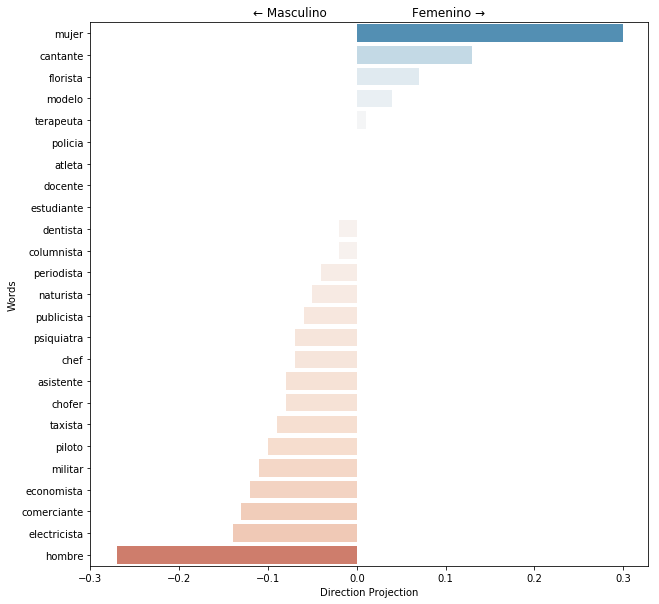

In [218]:
import matplotlib.pylab as plt

f, ax = plt.subplots(1, figsize=(10, 10))

we_genero.plot_projection_scores(
    profesiones_neutras + espacio_f[:1] + espacio_m[:1],
    n_extreme=20,
    ax=ax);

In [219]:
we_genero.calc_direct_bias(profesiones_neutras, c=None)

0.06407627389442337

## 4.4 Mitigación del sesgo de género

La estrategia que vimos para mitigar sesgo de género consiste en eliminar la proyección de género de las palabras de una lista de palabras neutras, y después normalizar. 

El problema que tenemos para trasladar esta estrategia directamente al castellano es que la lista de palabras neutras es mucho más difícil de obtener que para el inglés. En inglés la lista de palabras neutras tenía más de 26000 palabras, porque se definía como el complemento de la lista de palabras con género morfológicamente marcado, que son muy pocas en inglés y por lo tanto sencillas de listar.

Como hemos dicho, en castellano la mayor parte de palabras tienen género morfológico marcado, así que resultará difícil construir la lista de palabras neutras.

¿Qué pasa si la lista de palabras neutras es pequeña?

### Lista de palabras neutras corta

Veamos qué pasa si usamos solamente las palabras de profesiones neutras como lista de palabras neutras para mitigar el sesgo. Esta lista tiene muy pocas palabras.

In [224]:
len(profesiones_neutras)

23

In [225]:
we_genero_debias = we_genero.debias(method = 'neutralize' , neutral_words= profesiones_neutras, inplace=False)


2021-06-16 01:28:34,401 : precomputing L2-norms of word weight vectors
2021-06-16 01:28:36,214 : precomputing L2-norms of word weight vectors


In [ ]:
w2v_small_gender_debias = w2v_small_gender_bias.debias(method='neutralize', inplace=False)

In [ ]:
Si medimos el sesgo después de la mitigación vemos que se ha reducido muchísimo! y el gráfico también indica lo mismo.

In [226]:
we_genero_debias.calc_direct_bias(profesiones_neutras, c=None)

8.23345780925669e-09

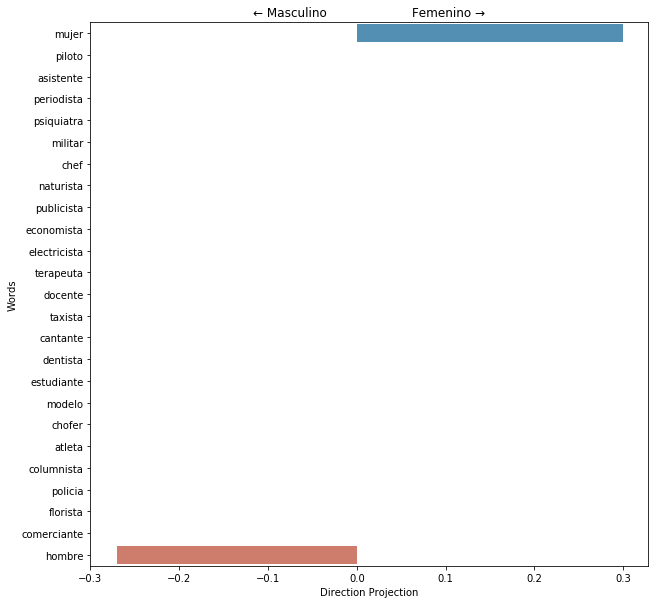

In [222]:
f, ax = plt.subplots(1, figsize=(10, 10))

we_genero_debias.plot_projection_scores(
    profesiones_neutras + espacio_f[:1] + espacio_m[:1],
    n_extreme=20,
    ax=ax);

Vamos a hacer una exploración cualitativa de cómo se ha reducido el sesgo:

In [229]:
print('estudiante:',
      'antes =', we_genero.model['estudiante'] @ we_genero.direction,
      'después = ', we_genero_debias.model['estudiante'] @ we_genero_debias.direction)

estudiante: antes = -0.0048034997 después =  -1.2823875e-10


Pero, ¿qué pasa con las palabras que no están en la lista?

In [227]:
print('ingeniero:',
      'antes =', we_genero.model['ingeniero'] @ we_genero.direction,
      'después = ', we_genero_debias.model['ingeniero'] @ we_genero_debias.direction)

ingeniero: antes = -0.24747832 después =  -0.24747832


In [228]:
print('laboralista:',
      'antes =', we_genero.model['laboralista'] @ we_genero.direction,
      'después = ', we_genero_debias.model['laboralista'] @ we_genero_debias.direction)

laboralista: antes = -0.08559768 después =  -0.08559768


Esta aproximación sólo elimina el sesgo de las palabras que pongamos en la lista! 

Pero si en el castellano la mayoría de palabras tienen género marcado morfológicamente ¿qué palabras podemos poner en una lista de palabras neutras con respecto al género?

## 4.5 Palabras de género semántico neutro para el castellano


* Palabras de categorías gramaticales sin género: verbos, adverbios, preposiciones
* Palabras abstractas, cuyo género morfológico no tiene una correspondencia con un género semántico
* Palabras de colectivos, igual
* Más palabras sin género marcado morfológicamente, como las terminadas en -ble, -nte

Ahora bien, si estas palabras no tienen género semántico, quizás no nos sirven para mitigar sesgo porque no están sesgadas... ¿o sí?

### Categorías gramaticales sin género

In [257]:
verbos = [ 
          'comprar',
          'vender',
          'dormir',
          'despertar',
          'soñar',
          'llorar',
          'gritar',
          'hablar',
          'preguntar',
          'pensar',
          'inventar',
          'bailar',
          'cantar',
          'cocinar',
          'sentir',
          'bordar',
          'tejer',
          'coser',
          'razonar',
          'argumentar',
          'cursar',
          'programar'
]

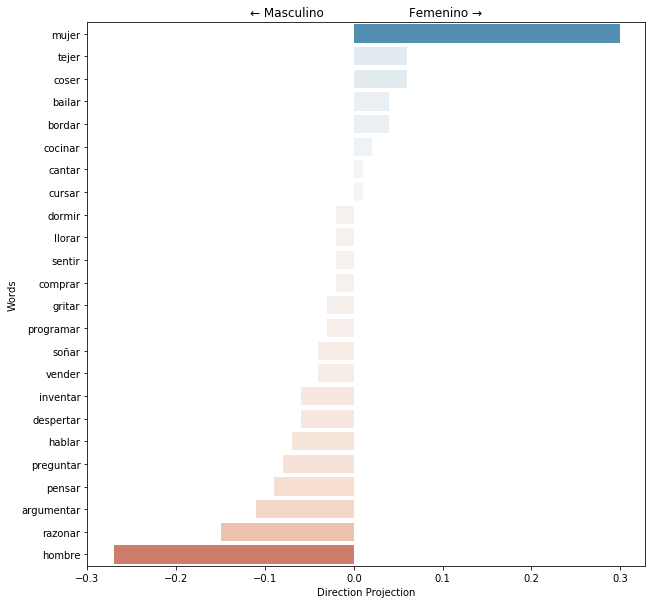

In [258]:
f, ax = plt.subplots(1, figsize=(10, 10))

we_genero.plot_projection_scores(
    verbos + ['hombre'] + ['mujer'],
    n_extreme=20,
    ax=ax);

### Colectivos

Las palabras referidas a colectivos se han usado muchas veces en lenguaje igualitario, porque, aunque tienen género morfológico, ese género no se corresponde con el género de las personas que componen el colectivo.

Podríamos usar las palabras de colectivos profesionales también como indicadores de género neutro!

In [152]:
profesiones_colectivos = [
'ingeniería',
'arquitectura',
'psicología',
'enfermería',
'medicina',
'carpintería',
'presidencia',
'biología',
'cocina',
'docencia',
'abogacía',
'cirugía',
'neurocirugía',
'actuación',
'música',
'canto'
]

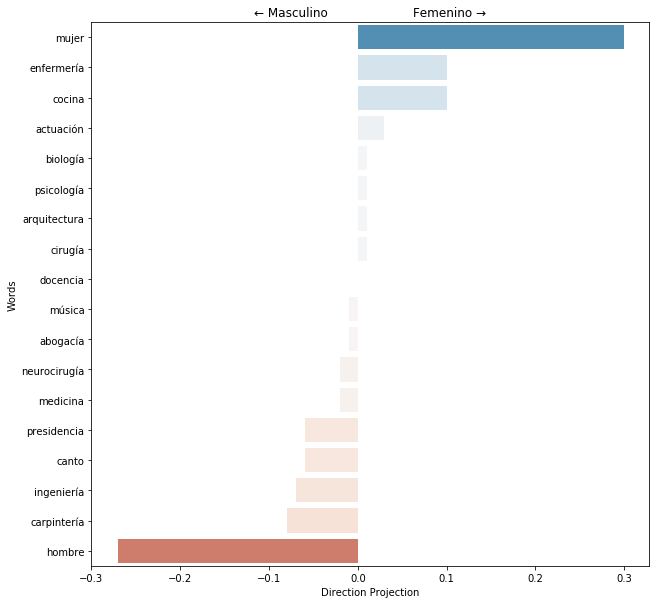

In [153]:
f, ax = plt.subplots(1, figsize=(10, 10))

we_genero.plot_projection_scores(
    profesiones_colectivos + ['hombre'] + ['mujer'],
    n_extreme=20,
    ax=ax);

### Sustantivos abstractos

In [141]:
sustantivos_abstractos = [
'inteligencia',
'belleza',
'humildad',
'sabiduría',
'poder',
'cariño',
'bondad',
'ambición',
'delicadeza',
'amabilidad',
'paciencia',
'popularidad',
'fama',
'generosidad',
'honestidad',
'canto',
'maldad',
'soberbia',
'violencia'
]


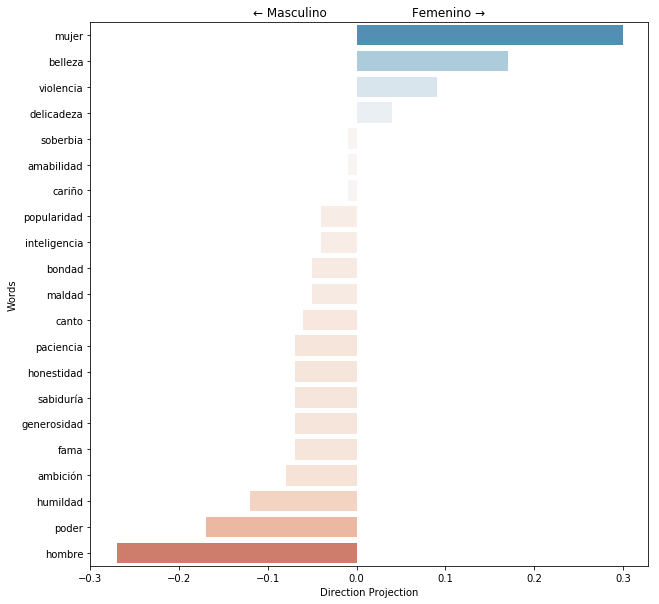

In [142]:
f, ax = plt.subplots(1, figsize=(10, 10))

we_genero.plot_projection_scores(
    sustantivos_abstractos + ['hombre'] + ['mujer'],
    n_extreme=20,
    ax=ax);

### Adjetivos neutros

In [139]:
adjetivos_neutros = [
'inteligente',
'humilde',
'amable',
'dulce',
'audaz',
'paciente',
'popular',
'flexible',
'grande',
'brillante',
'inocente',
'fácil',
'agradable',
'infeliz',
'capaz',
'difícil',
'temperamental',
]

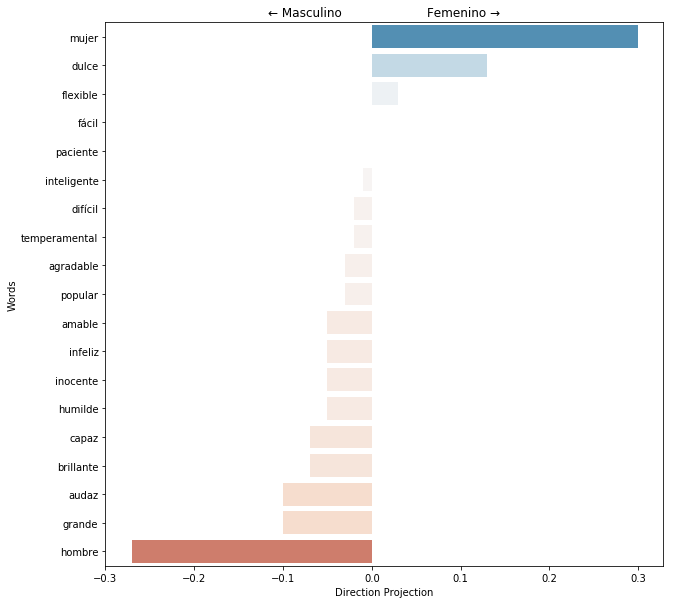

In [140]:
f, ax = plt.subplots(1, figsize=(10, 10))

we_genero.plot_projection_scores(
    adjetivos_neutros + ['hombre'] + ['mujer'],
    n_extreme=20,
    ax=ax);

## 4.6 ¿Podemos incorporar palabras con género morfológico marcado?

Incluso usando todas estas palabras con género semántico neutro, habrá muchas palabras que quedarán sesgadas, porque no se habrán podido neutralizar.

¿Habrá alguna forma de incorporar las palabras con género marcado morfológicamente para hacer la neutralización?

Veamos algunas de sus propiedades

In [267]:
palabras_con_genero = ['gato','gata']

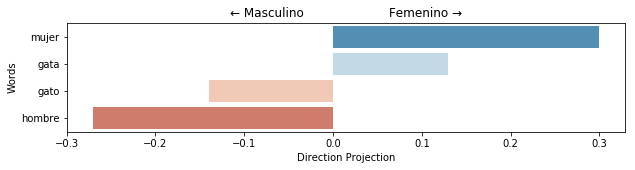

In [270]:
f, ax = plt.subplots(1, figsize=(10, 2))

we_genero.plot_projection_scores(
    palabras_con_genero + espacio_f[:1] + espacio_m[:1],
    n_extreme=20,
    ax=ax);

In [114]:
profesiones_con_genero = [
                          'arquitecta', 'arquitecto',
                          'ingeniera', 'ingeniero',
                          'diseñadora', 'diseñador',
                          'doctor', 'doctora',
                          'abogada', 'abogado',
                          'profesor', 'profesora',
                          'contador','contadora',
                          'científico', 'científica',
                          'biólogo', 'bióloga',
                          'cocinera', 'cocinero',
                          'psicóloga','psicólogo',
                          'enfermera', 'enfermero',
                          'obrera', 'obrero',
                          'actor', 'actriz'
                          ]

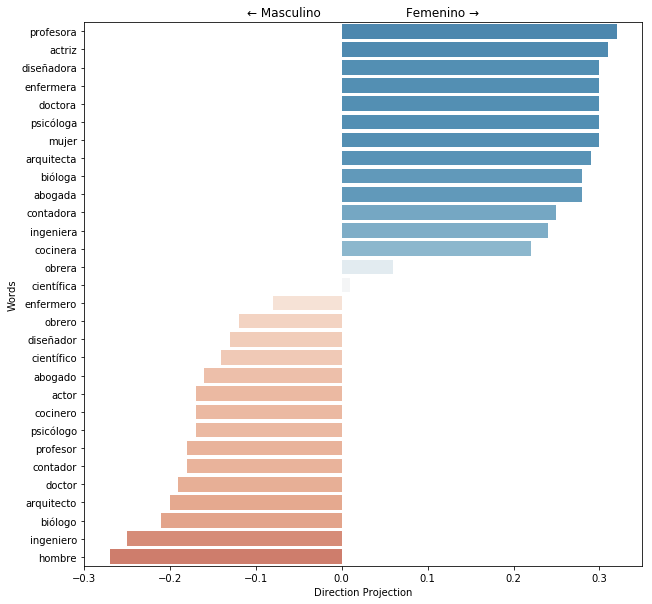

In [115]:
f, ax = plt.subplots(1, figsize=(10, 10))

we_genero.plot_projection_scores(
    profesiones_con_genero + espacio_f[:1] + espacio_m[:1],
    n_extreme=20,
    ax=ax);

Las profesiones con género morfológico femenino están más hacia el lado femenino que las profesiones masculinas hacia el lado masculino.


Podemos buscar otra forma de calcular el sesgo cuando la mayoría de las palabras tienen una forma femenina y otra masculina: podemos medir el sesgo como el valor absoluto de la diferencia entre la proyección de cada palabra. Cuanto más grande sea esa diferencia, más estereotipada hacia uno de los dos géneros está esa profesión.

In [130]:
gender_direction = we_genero.direction

In [262]:
abs(gender_direction @ we.word_vec('gato')) - abs(gender_direction @ we.word_vec('gata'))

0.0015478581

In [131]:
abs(gender_direction @ we.word_vec('arquitecta')) - abs(gender_direction @ we.word_vec('arquitecto'))

0.098457724

In [133]:
abs(gender_direction @ we.word_vec('médica')) - abs(gender_direction @ we.word_vec('médico'))

-0.024638467

In [118]:
abs(gender_direction @ we.word_vec('enfermera')) - abs(gender_direction @ we.word_vec('enfermero'))

0.21549931

# Resources

## [Doing Data Science Responsibly - Resources](https://handbook.responsibly.ai/appendices/resources.html)

In particular:

- Timnit Gebru and Emily Denton - CVPR 2020 - [FATE Tutorial](https://youtu.be/-xGvcDzvi7Q) [Video]

- Rachel Thomas - fast.ai - [Algorithmic Bias (NLP video 16)](https://youtu.be/pThqge9QDn8) [Video]

- Solon Barocas, Moritz Hardt, Arvind Narayanan - [Fairness and machine learning - Limitations and Opportunities](https://fairmlbook.org/) [Textbook]

## [Course // Responsible AI, Law, Ethics & Society](https://learn.responsibly.ai/)

## [Course // Ethic aspects in AI (in spanish, from UBA)](https://campus.exactas.uba.ar/course/view.php?id=1477&section=0)


## Non-Technical Overview with More Downstream Application Examples
- [Google - Text Embedding Models Contain Bias. Here's Why That Matters.](https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html)
- [Kai-Wei Chang (UCLA) - What It Takes to Control Societal Bias in Natural Language Processing](https://www.youtube.com/watch?v=RgcXD_1Cu18)
- Sun, T., Gaut, A., Tang, S., Huang, Y., ElSherief, M., Zhao, J., ... & Wang, W. Y. (2019). [Mitigating Gender Bias in Natural Language Processing: Literature Review](https://arxiv.org/pdf/1906.08976.pdf). arXiv preprint arXiv:1906.08976.

## Critical Prespective on Bias in NLP

Blodgett, S. L., Barocas, S., Daumé III, H., & Wallach, H. (2020). [Language (Technology) is Power: A Critical Survey of "Bias" in NLP](https://arxiv.org/pdf/2005.14050.pdf). arXiv preprint arXiv:2005.14050.



## Additional Related Work

- **Software Framework for Word Embedding Bias**
  - [WEFE: The Word Embeddings Fairness Evaluation Framework](https://wefe.readthedocs.io/en/latest/)

- **Understanding Bias**
    - Ethayarajh, K., Duvenaud, D., & Hirst, G. (2019, July). [Understanding Undesirable Word Embedding Associations](https://arxiv.org/pdf/1908.06361.pdf). In Proceedings of the 57th Annual Meeting of the Association for Computational Linguistics (pp. 1696-1705). - **Including critical analysis of the current metrics and debiasing methods (quite technical)**

  - Brunet, M. E., Alkalay-Houlihan, C., Anderson, A., & Zemel, R. (2019, May). [Understanding the Origins of Bias in Word Embeddings](https://arxiv.org/pdf/1810.03611.pdf). In International Conference on Machine Learning (pp. 803-811).

- **Discovering Bias**
  - Swinger, N., De-Arteaga, M., Heffernan IV, N. T., Leiserson, M. D., & Kalai, A. T. (2019, January). [What are the biases in my word embedding?](https://arxiv.org/pdf/1812.08769.pdf). In Proceedings of the 2019 AAAI/ACM Conference on AI, Ethics, and Society (pp. 305-311). ACM.
    Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories
  
  - Chaloner, K., & Maldonado, A. (2019, August). [Measuring Gender Bias in Word Embeddings across Domains and Discovering New Gender Bias Word Categories](https://www.aclweb.org/anthology/W19-3804). In Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 25-32).

- **Mitigating Bias**
  - Maudslay, R. H., Gonen, H., Cotterell, R., & Teufel, S. (2019). [It's All in the Name: Mitigating Gender Bias with Name-Based Counterfactual Data Substitution](https://arxiv.org/pdf/1909.00871.pdf). arXiv preprint arXiv:1909.00871.
  
  - Shin, S., Song, K., Jang, J., Kim, H., Joo, W., & Moon, I. C. (2020). [Neutralizing Gender Bias in Word Embedding with Latent Disentanglement and Counterfactual Generation](https://arxiv.org/pdf/2004.03133.pdf). arXiv preprint arXiv:2004.03133.
  
  - Zhang, B. H., Lemoine, B., & Mitchell, M. (2018, December). [Mitigating unwanted biases with adversarial learning](https://dl.acm.org/doi/pdf/10.1145/3278721.3278779?casa_token=yd1KGvVDBGwAAAAA:YzUT7d8Fq4bOV2b5M-CB43NLqIReW7wx2EaZj0omJ0ncbZF_pkPFoyV6WHWIBnG_HKIRqiG7FWFjsA). In Proceedings of the 2018 AAAI/ACM Conference on AI, Ethics, and Society (pp. 335-340). [Demo](https://colab.research.google.com/notebooks/ml_fairness/adversarial_debiasing.ipynb)
  
- **Fairness in Classification**
  - Prost, F., Thain, N., & Bolukbasi, T. (2019, August). [Debiasing Embeddings for Reduced Gender Bias in Text Classification](https://arxiv.org/pdf/1908.02810.pdf). In Proceedings of the First Workshop on Gender Bias in Natural Language Processing (pp. 69-75).
  
  - Romanov, A., De-Arteaga, M., Wallach, H., Chayes, J., Borgs, C., Chouldechova, A., ... & Kalai, A. (2019, June). [What's in a Name? Reducing Bias in Bios without Access to Protected Attributes](https://arxiv.org/pdf/1904.05233.pdf). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 4187-4195).

- **Grammatical Gender**
  - Zhou, P., Shi, W., Zhao, J., Huang, K. H., Chen, M., & Chang, K. W. [Analyzing and Mitigating Gender Bias in Languages with Grammatical Gender and Bilingual Word Embeddings](https://aiforsocialgood.github.io/icml2019/accepted/track1/pdfs/47_aisg_icml2019.pdf). ICML 2019 - AI for Social Good. [Poster](https://aiforsocialgood.github.io/icml2019/accepted/track1/posters/47_aisg_icml2019.pdf)

  - Zhao, J., Mukherjee, S., Hosseini, S., Chang, K. W., & Awadallah, A. [Gender Bias in Multilingual Embeddings](https://www.researchgate.net/profile/Subhabrata_Mukherjee/publication/340660062_Gender_Bias_in_Multilingual_Embeddings/links/5e97428692851c2f52a6200a/Gender-Bias-in-Multilingual-Embeddings.pdf).

  - Gonen, H., Kementchedjhieva, Y., & Goldberg, Y. (2019). [How does Grammatical Gender Affect Noun Representations in Gender-Marking Languages?](https://arxiv.org/pdf/1910.14161.pdf). arXiv preprint arXiv:1910.14161.

- **Other**  
  - Zhao, J., Wang, T., Yatskar, M., Cotterell, R., Ordonez, V., & Chang, K. W. (2019, June). [Gender Bias in Contextualized Word Embeddings](https://arxiv.org/pdf/1904.03310.pdf). In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics: Human Language Technologies, Volume 1 (Long and Short Papers) (pp. 629-634). [slides](https://jyzhao.net/files/naacl19.pdf)


##### Complete example of using `responsibly` with Word2Vec, GloVe and fastText: http://docs.responsibly.ai/notebooks/demo-gender-bias-words-embedding.html

## Bias in NLP

Around dozen of papers on this field until 2019, but nowdays plenty of work is done. Two venues from back then:
- [1st ACL Workshop on Gender Bias for Natural Language Processing](https://genderbiasnlp.talp.cat/)
- [NAACL 2019](https://naacl2019.org/)